# Loan Approval Project

End-to-End Loan Approval Analysis and Machine Learning with Python 

### Table of Contents
1. Introduction  
   1.1 Purpose of the Dataset  
   1.2 Business Context  
   1.3 Source of Data  
   1.4 Structure of the Data  

2. Data Loading and Initial Checks  
   2.1 Loading the Dataset  
   2.2 Missing Values Check  
   2.3 Age Distribution and Filtering 
   2.4 Target Variable Distribution 

3. Exploratory Data Analysis (EDA)  
   3.1 Correlation Analysis  
   3.2 Categorical Feature Distributions
   3.3 Loan Intent and Approval Rates  
   3.4 Gender and Loan Approval  
   3.5 Home Ownership and Loan Approval  
   3.6 Education Level and Loan Approval  
   3.7 Previous Loan Defaults and Approval Outcomes

4. Machine Learning Integration
   4.1 Feature and Target Selection
   4.2 Train–Test Split and Class Imbalance Handling
   4.3 Random Forest Model
   4.4 XGBOOST
   4.5 Hyperparameter Tuning on XGBOOST 

6. Conclusion


### Methodology Note:
Synthetic Minority Oversampling Technique (SMOTE) was applied only to the training data to address class imbalance and avoid data leakage into the test set.


## 1. Introduction
This notebook presents an end-to-end workflow for analyzing loan application data and building machine learning models to predict loan approval outcomes.

### 1.1 Purpose of the Dataset  
The dataset contains information about individuals applying for bank loans. The primary goal is to explore whether certain applicant attributes can assist in predicting the likelihood of a loan being approved.

### 1.2. Business Context  
Accurate loan approval prediction is critical for financial institutions to minimize risk and ensure healthy lending practices. By analyzing the dataset, we can uncover patterns that may assist in risk assessment and decision making.

### 1.3 Source of data 
The dataset is sourced from Kaggle and is publicly available at: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

### 1.4 Structure of the data 

#### Categorical Data ####

- person_gender: Applicants gender as male or female
- person_education: Education level of the applicant such as Bachelor, Master, High School
- person_home_ownership: Status of home ownership, whether it is rent, own, or mortgage
- loan_intent: Reason for requesting loan such as educaton, medical, or venture project
- previous_loan_defaults_on_file: Whether an applicant has defaulted on a previous loan represented as “Yes” or “No”
- loan_status: Whether the loan was approved (marked as ‘1’) or rejected (“marked as “0’)

#### Numerical Data ####

- person_age : Age of applicant in years
- person_income: Income measured in USD(\$)
- person_emp_exp: Number of years in employment
- loan_amnt: Loan amount in USD(\$)
- loan_int_rate: Interest rate related to the loan
- loan_percent_income: Loan as a percentage in relation to the applicants income
- cb_person_cred_hist_length: Length of credit history measured in years
- credit_score: Applicants current credit score as a numerical value

#### Missing Data ####
The are no missing values that are initially observed but an Exploratory Data Analysis (EDA) will be conducted in order to confirm this, and decide on the best approach to handle these, as well as make preprocessing decisions before applying the machine learning algorithms. 

**Next steps**
The next stage of the analysis involves EDA to better understand feature distributions, relationships between variables, and potential challenges. These will be used to guide decisions in later stages. 

# 2. Data Loading and Initial Checks #

**Here the dataset is loaded and basic checks are performed to understand its structure, data types, and target distribution.**


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ( classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

np.random.seed(42)

sns.set_theme(style='whitegrid')
APPROVE_COLOR = '#16A34A'  
REJECT_COLOR = '#F97316'   
NEUTRAL_COLOR = '#64748B'  


## 2.1 Loading the Dataset ##

In [78]:
#load dataset
df = pd.read_csv("loan_data.csv")
df.shape

(45000, 14)

In [79]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

In [80]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [81]:
df.tail()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1
44999,24.0,male,High School,51609.0,1,RENT,6665.0,DEBTCONSOLIDATION,17.05,0.13,3.0,628,No,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [83]:
#summary statistics for numerical variables 
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [84]:
#list all column names 
target_col = "loan_status"

categorical_cols = df.select_dtypes(include="object").columns.tolist()
numerical_cols = [
    col for col in df.select_dtypes(include=["int64", "float64"]).columns
    if col != target_col
]

categorical_cols, numerical_cols

(['person_gender',
  'person_education',
  'person_home_ownership',
  'loan_intent',
  'previous_loan_defaults_on_file'],
 ['person_age',
  'person_income',
  'person_emp_exp',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length',
  'credit_score'])

## Summary

The dataset contains **45,000** loan applications with **14 columns**. This covers applicant demographics such as age, financial information, credit history, and loan related attributes.

The target variable **loan_status** is imbalanced. Approximately **77.8%** of applications are rejected (0) and **22.2%** are approved (1), which is important because accuracy alone may be misleading. Therefore, evaluation metrics such as precision, recall, and ROC-AUC will be used later.

Next, missing values and general data quality issues are checked to confirm the dataset is suitable for preprocessing and modeling.

## 2.2 Missing Values Check 

In [85]:
#Checking any missing values across all columns 
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

**Summary:** The dataset contains no missing values, which simplifies the data cleaning process and allows the analysis to proceed without imputation or any removal of rows.

## 2.3 Age Distribution and Filtering ##

In [86]:
#check summary stats for age
print("Age summary before filtering:")
print(df['person_age'].describe())

#remove unrealistic age values
df = df[(df['person_age'] >= 18) & (df['person_age'] <= 100)]

#check summary stats for age again 
print("\nAge summary after filtering:")
print(df['person_age'].describe())

#confirm dataset shape
print("\nDataset shape after filtering:", df.shape)


Age summary before filtering:
count    45000.000000
mean        27.764178
std          6.045108
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

Age summary after filtering:
count    44993.000000
mean        27.748428
std          5.909737
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max         94.000000
Name: person_age, dtype: float64

Dataset shape after filtering: (44993, 14)


**Age summary** Summary statistics reveal an unrealistic value of **144** for age so this was removed prior to analysis by restricting applicant ages to a reasonable range of **18** to **100**). After filtering, the dataset contains **44,993** observations, with summary statistics remaining mainly unchanged sugesting that the removal had little impact on overall distributions.

## 2.4 Target Variable Distribution ##

In [87]:
#check the distribution of target variable 
df['loan_status'].value_counts()

loan_status
0    34993
1    10000
Name: count, dtype: int64

**Target variable summary:** The target variable loan_status is imbalanced. Approximately 22.2% of applications are approved, while 77.8% are rejected. Approved:rejected ≈ 1:3.5. This imbalance is important to consider during later stages since as accuracy alone may be misleading. Therefore, additional evaluation metrics will be used. 

In [88]:
#value counts for categorical columns
for col in categorical_cols:
    print(f"\n {col} ")
    print(df[col].value_counts())


 person_gender 
person_gender
male      24836
female    20157
Name: count, dtype: int64

 person_education 
person_education
Bachelor       13396
Associate      12026
High School    11970
Master          6980
Doctorate        621
Name: count, dtype: int64

 person_home_ownership 
person_home_ownership
RENT        23440
MORTGAGE    18485
OWN          2951
OTHER         117
Name: count, dtype: int64

 loan_intent 
loan_intent
EDUCATION            9151
MEDICAL              8548
VENTURE              7815
PERSONAL             7551
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

 previous_loan_defaults_on_file 
previous_loan_defaults_on_file
Yes    22856
No     22137
Name: count, dtype: int64


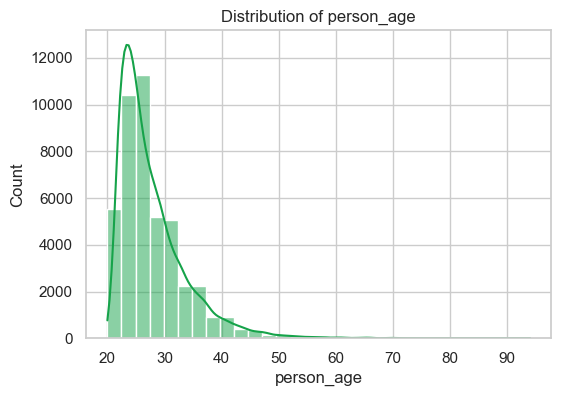

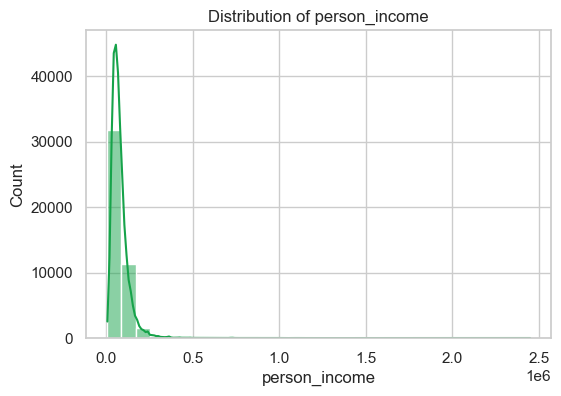

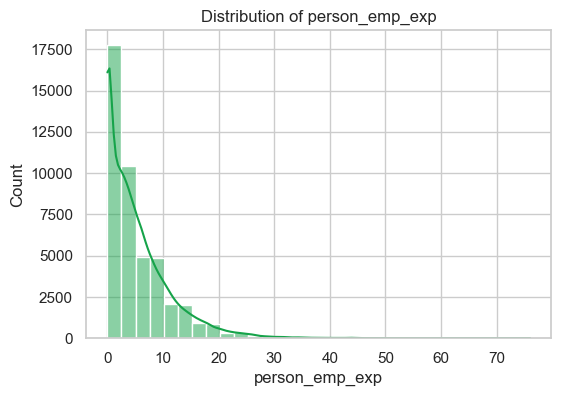

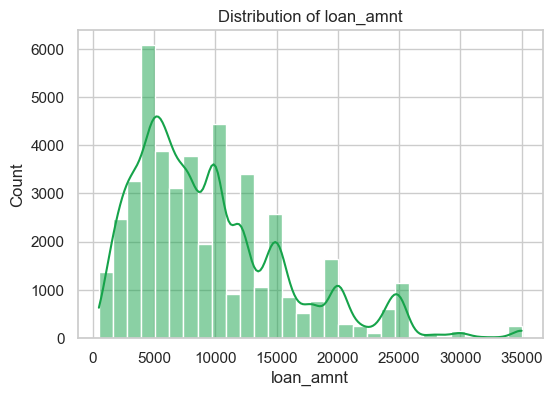

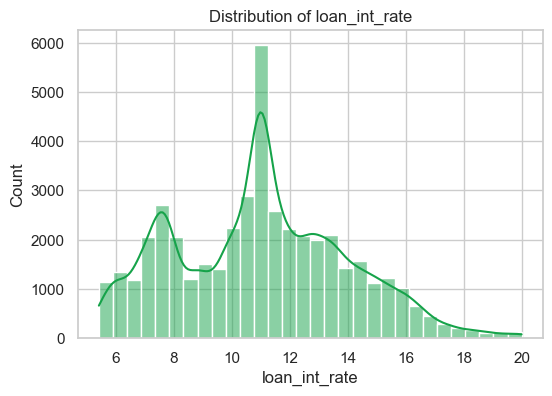

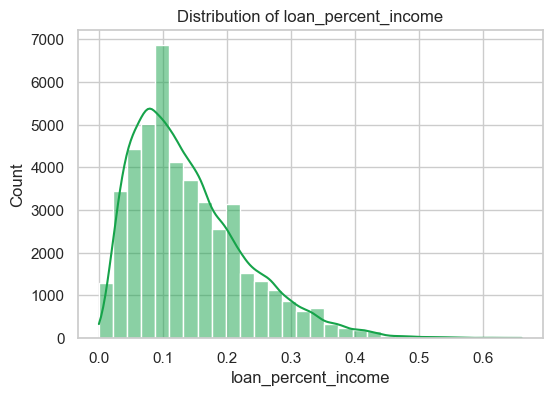

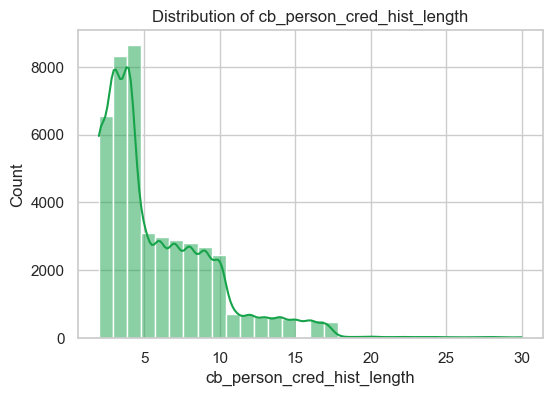

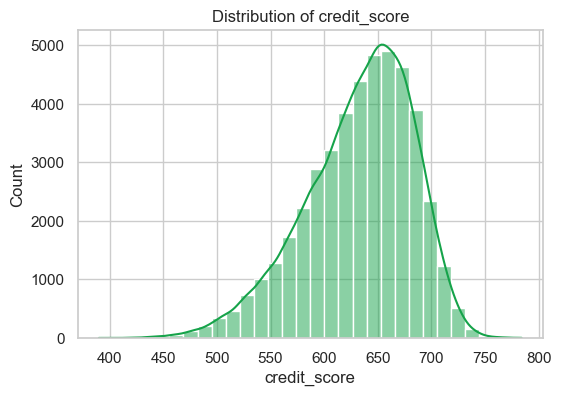

In [89]:
#histograms for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True, color=APPROVE_COLOR)
    plt.title(f"Distribution of {col}")
    plt.show()


#### Results ####
- **Loan Status**: The acceptance rate for this dataset is 22.2%, with a ratio of 1:3.5, so the target variable appears imbalanced. Loans are declined more often than they are accepted so it is worth exploring what factors could effect this. 
- **Gender**: There are 4,682 more men than women which could introduce a slight bias and skew the values. However, since the dataset has is relatively large with 45,000 instances, this may not have a huge a impact on the analysis, but it is worth noting and investigating when comparing with the target variable (Loan status). A larger dataset with a relatively even distribution can be more generalisable.
- **Education**: There are 29.78% of applicants whith Bachelors degrees, which has the highest weighting. Most people in the datset have qualifications beyond highschool (73.3%). One thing to note is the data does not show whether or not they are currently completing the selected degree or have already completed it. Furthermore, since higher education often correlates with income, the interaction between education and income on loan approval should be explored. 
- **Home Ownership**: The most common type, with over half of applicants, is renting (52%). The second most common is mortgage (41% of applicants) and while this does suggest financial staility it also does mean applicants have current and ongoing debt obligations to this. A small portion of applicants own their home which implies higher financial responsibility or potentially a higher income. The 'Other" category is selected by the lowest number of applicants (0.26%).
- **Loan Intent**: The dataset shows there are 6 main reasons for applying for the loan: Education, Medical, Venture, personal, Debt Consolidation and Home improvement. They are more proportional in terms of split but Education was the most common.
- **Age**: The distribution is heavily right skewed with most applicants in their 20s and 30s. With younger candidates dominating this may have an effect on other variables within the dataset such as income, previous defaults etc, compared to the older, more established applicants.

# 3. Exploratory Data Analysis (EDA) #

## 3.1 Correlation Analysis  ##

                            person_age  person_income  person_emp_exp  \
person_age                    1.000000       0.144634        0.952294   
person_income                 0.144634       1.000000        0.134666   
person_emp_exp                0.952294       0.134666        1.000000   
loan_amnt                     0.052080       0.312441        0.045792   
loan_int_rate                 0.012757      -0.001361        0.016055   
loan_percent_income          -0.041955      -0.287149       -0.038434   
cb_person_cred_hist_length    0.878659       0.128832        0.840146   
credit_score                  0.174648       0.025462        0.182592   
loan_status                  -0.020545      -0.169034       -0.019529   

                            loan_amnt  loan_int_rate  loan_percent_income  \
person_age                   0.052080       0.012757            -0.041955   
person_income                0.312441      -0.001361            -0.287149   
person_emp_exp               0.045792 

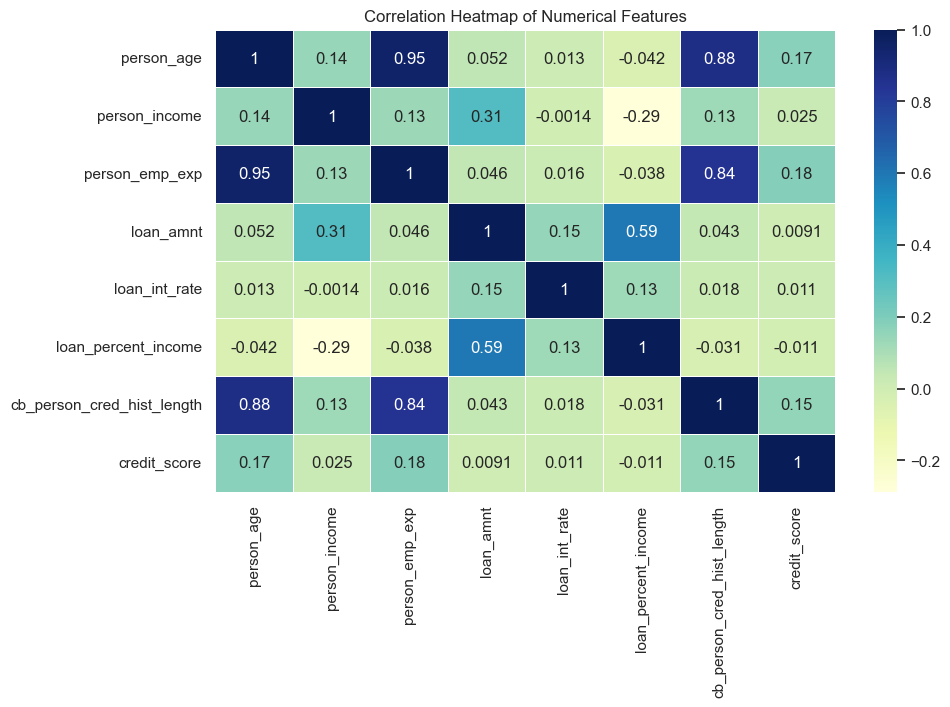

In [90]:
#correlation matrix 

correlation_matrix = df.corr(numeric_only=True)

print(correlation_matrix)

# Correlation heatmap of numerical variables
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


#### Correlation Analysis Key takeaway ####
- **Person Age**: There is a strong positive correlation between **Person Age** and **Employement experience (0.95)** AND **Person Age** and **Credit History Length**. This can be explained with the idea of older individuals tending to have more time in employment as well as an increased chance of having had a credit history.
- **Loan Amount**: There is a moderate positive correlation between **Loan Amount** and **Loan percent income** suggesting that larger loans seem to consume a bigger share of the applicants income.
- The positive correlation between **loan_percent_income** and **loan_status** likely reflects risk based lending rather than increased approval likelihood. Applicants who are approved despite higher risk may receive loans that consume a larger proportion of income.
- A similar weak positive correlation (0.33) is also shown between **loan interest rate** and **Loan status** suggesting loans with higher risk may still be approved but this will be accompanied by a higher interest rate.

## 3.2 Categorical Feature Distributions ##

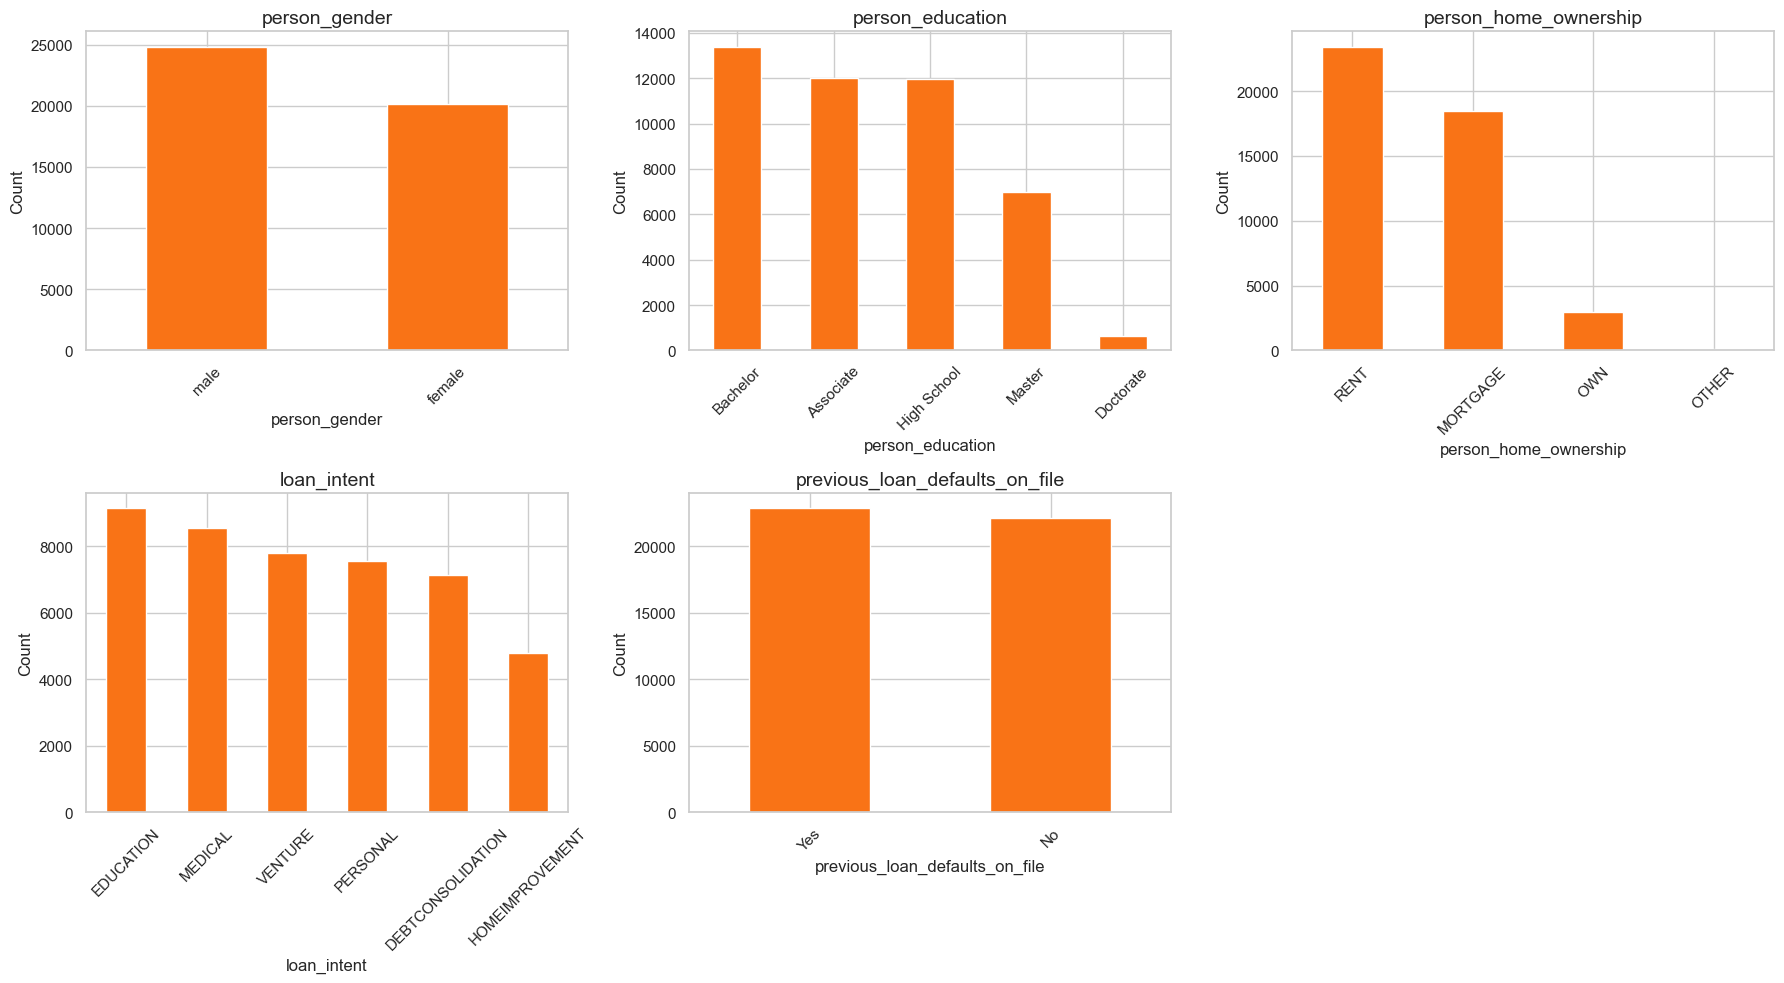

In [91]:
#visualise categorical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, column in enumerate(categorical_cols):
    df[column].value_counts().plot(kind='bar', ax=axes[i], color=REJECT_COLOR)
    axes[i].set_title(column, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 3.3 Loan Intent and Approval Rates ##

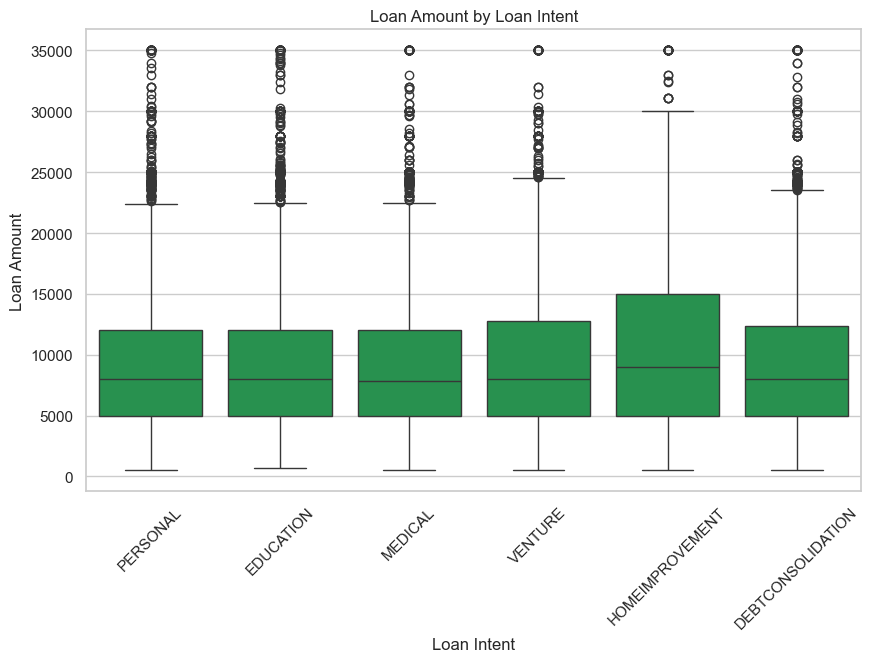

In [92]:
#box plot to show loan amounts for each loan intent category
plt.figure(figsize=(10,6))
sns.boxplot(x='loan_intent', y='loan_amnt', data=df, color=APPROVE_COLOR)
plt.title('Loan Amount by Loan Intent')
plt.ylabel('Loan Amount')
plt.xlabel('Loan Intent')
plt.xticks(rotation=45)
plt.show()

#### Key Takeaways from Loan amount and intent ####
- The box plot shows the distribution of loan amounts across the loan intent categories.
- Each category exhibits a wide range of loan amounts, with no single category consistently having high or low loans.
- The median loan amounts across categories are relatively similar and outliers indicate some unusually large or small loans in each category.
- Home improvement loans have the largest whiskers, suggesting a wider overall spread in loan amounts compared to other categories.
- Despite the wide spread, home improvement has relatively few outliers, meaning most of the extreme values are still within the whisker range.
- Overall, the plot highlights the variability within each loan intent category more clearly than a scatter plot would.

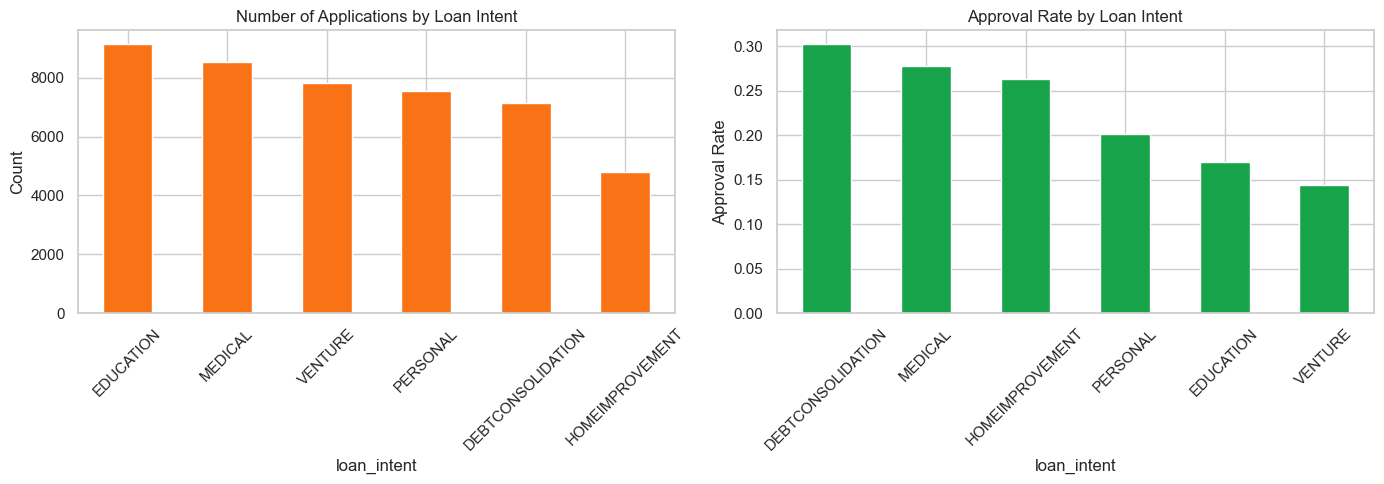

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

df['loan_intent'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=REJECT_COLOR
)
axes[0].set_title('Number of Applications by Loan Intent')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

(df.groupby('loan_intent')['loan_status']
   .mean()
   .sort_values(ascending=False)
   .plot(kind='bar', ax=axes[1], color=APPROVE_COLOR)
)
axes[1].set_title('Approval Rate by Loan Intent')
axes[1].set_ylabel('Approval Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Key takeaway ####
**Medical Loans** were the most likely to be approved suggesting lenders may see these and more essential and lower risk, and have a higher justification. **Debt consolidation** closely follows, which could suggest lenders may be aiming to reduce overall financial risk, and borrowers will also have more predictable repayment behaviour. **Education** and **personal** were had similar approval numbers, suggesting that lenders may view both as moderately low risk. **Home improvement** could suggest a low-risk, however the borrowing amount could impact the likelihood of this getting approved. **Venture loans** had the lowest approval rates which could be due to the higher risk associated with a new business ventures, from uncertain cash flow and limited understanding of track record. 
**Overall trend:** Approval rates seem to correlate with perceived risk and purpose of the loan.

## 3.4 Gender and Loan Approval ##

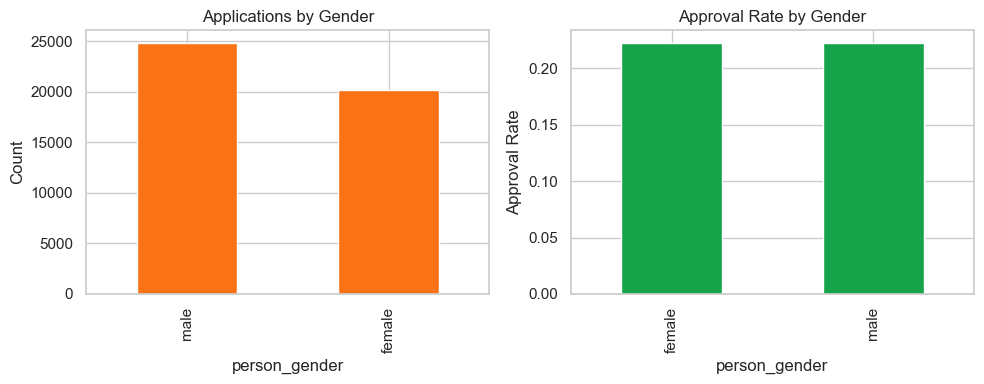

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

df['person_gender'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=REJECT_COLOR
)
axes[0].set_title('Applications by Gender')
axes[0].set_ylabel('Count')

(df.groupby('person_gender')['loan_status']
   .mean()
   .plot(kind='bar', ax=axes[1], color=APPROVE_COLOR)
)
axes[1].set_title('Approval Rate by Gender')
axes[1].set_ylabel('Approval Rate')

plt.tight_layout()
plt.show()


#### Gender & Loan Approval Key Takeaway ####
- More males than females were approved for loans which this may suggest that males are more lilely to be approved to Loans. However, this could be due to other factors that influence the population in the dataset such as salary and age.
- It is also worth noting that there are more males than females in the dataset so this is another factor which could have potentially influenced this result.

## 3.5 Home Ownership and Loan Approval ##

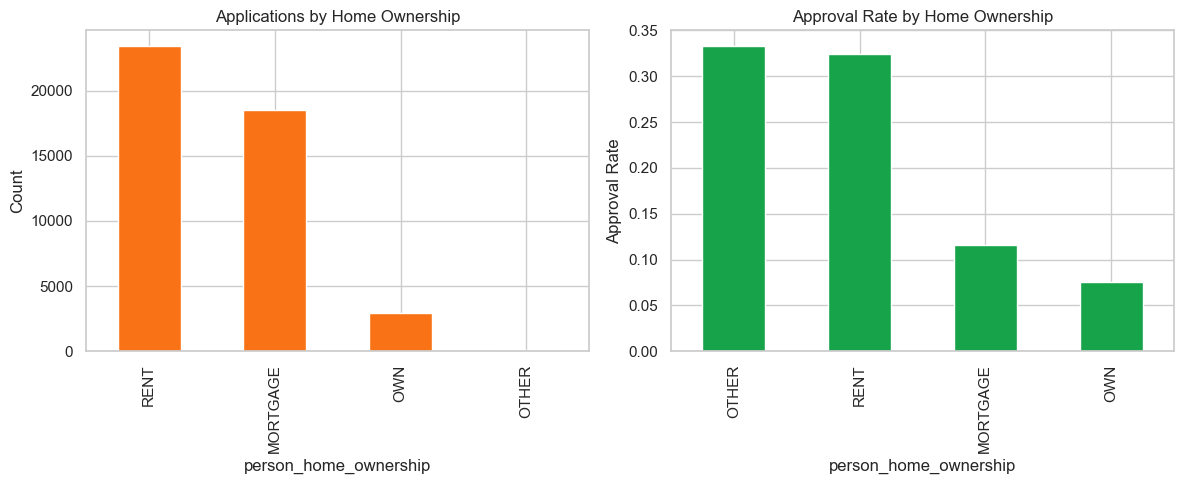

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

df['person_home_ownership'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=REJECT_COLOR
)
axes[0].set_title('Applications by Home Ownership')
axes[0].set_ylabel('Count')

(df.groupby('person_home_ownership')['loan_status']
   .mean()
   .sort_values(ascending=False)
   .plot(kind='bar', ax=axes[1], color=APPROVE_COLOR)
)
axes[1].set_title('Approval Rate by Home Ownership')
axes[1].set_ylabel('Approval Rate')

plt.tight_layout()
plt.show()


#### Home Ownership & Loan Approval Key takeaway ####
Renters account for the highest share of applications and approvals in reflecting their prevalence in the dataset. Approval rate comparisons provide a clearer picture of likelihood and suggest that home ownership status alone does not fully determine approval outcomes.

## 3.6 Education Level and Loan Approval ##

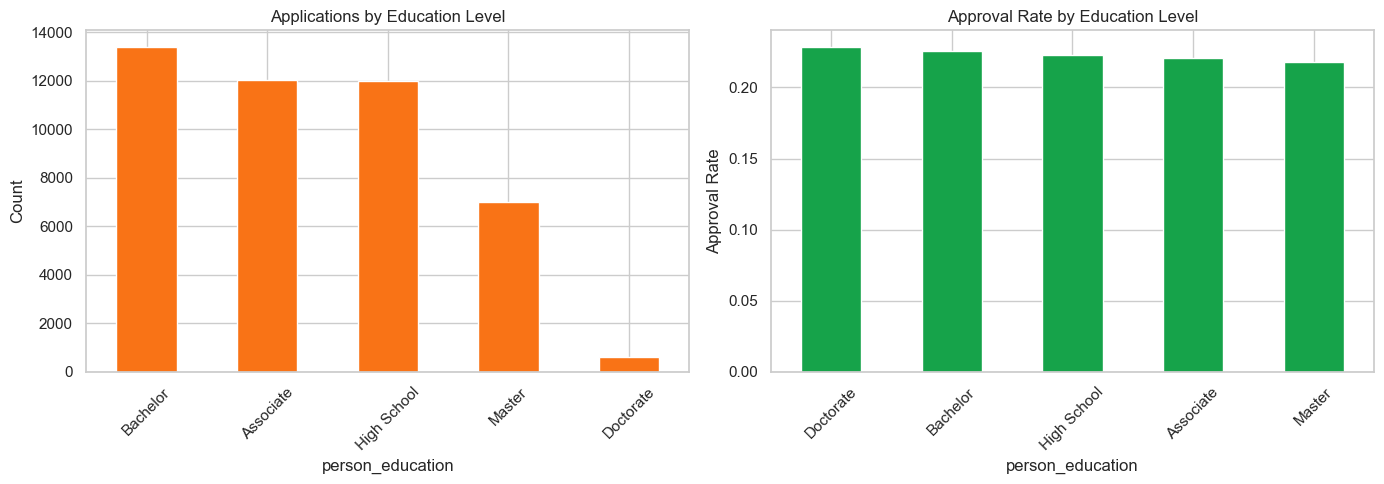

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

df['person_education'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=REJECT_COLOR
)
axes[0].set_title('Applications by Education Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

(df.groupby('person_education')['loan_status']
   .mean()
   .sort_values(ascending=False)
   .plot(kind='bar', ax=axes[1], color=APPROVE_COLOR)
)
axes[1].set_title('Approval Rate by Education Level')
axes[1].set_ylabel('Approval Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Education Level & Loan Approval Key takeaway ####
- Of the approved loans, the highest portion of candidates hold a Bachelors degree (30.2%) and the lowest portion hold a Doctorate (1.4%).
- A large portion of the approved candidates hold a degree suggesting they may be more likely to be approved.
- However, this could be due to other factors such as the degree reflecting the proportions of the population.For example, less people hold a doctorate compared to a Bachelors.

## 3.7 Previous Loan Defaults and Approval Outcomes ##

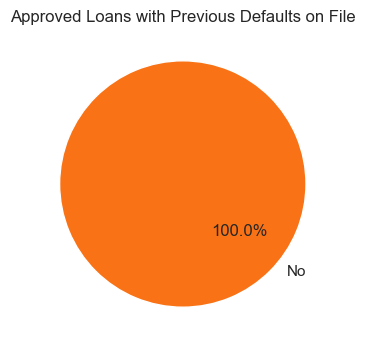

In [97]:
#defining approved loans
approved_loans = df[df['loan_status'] == 1]

#understand candidates were approved with previous debt on file
approved_with_prev_debt = approved_loans['previous_loan_defaults_on_file'].value_counts()

plt.figure(figsize=(4, 4), facecolor='white')
plt.pie(
    approved_with_prev_debt.values,
    labels=approved_with_prev_debt.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=[REJECT_COLOR, APPROVE_COLOR]  # only one category exists
)
plt.title('Approved Loans with Previous Defaults on File')
plt.show()


#### Previous Loan Defaults Key takeaway ####
- None of the approved loans in this dataset have previous defaults on file.
- This suggests it may be more difficult to be approved for a loan if a candidate has previous defaults on file, and candidates may be disqualified for this reason.
- This feature will be handled carefully during modeling to avoid dominating predictions.


# 4. Machine Learning Integration

This section uses predictive modeling to estimate loan approval outcomes using supervised machine learning. A Random Forest classifier is trained and evaluated as a baseline model to capture non linear relationships and feature interactions.

To avoid data leakage and unrealistic performance, variables determined post approval and those acting as strict approval rules (as established in the EDA) are excluded from modeling.


## 4.1 Feature and Target Selection

The target variable is **loan_status**, which indicates whether a loan was approved (1) or rejected (0).

The following features were excluded:
- **loan_int_rate**, as interest rate is determined after loan approval and would introduce data leakage  
- **previous_loan_defaults_on_file**, as EDA and previous runs of the classifer showed it used this as a rule and dominated predictions.

All remaining categorical variables were one-hot encoded prior to modeling.


In [98]:
#feature/target Split

X = df.drop(
    ['loan_status', 'previous_loan_defaults_on_file', 'loan_int_rate'],
    axis=1
)

y = df['loan_status']

X_encoded = pd.get_dummies(X, drop_first=True)

## 4.2 Train–Test Split and Class Imbalance Handling

The dataset was split into training and testing sets using a 70/30 split, stratified by the target variable to preserve class proportions.

Given the imbalance in loan approvals, SMOTE (Synthetic Minority Oversampling Technique) was applied **only to the training data** to improve the model’s ability to learn patterns associated with approved loans while avoiding data leakage.

In [99]:
#train/test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
#SMOTE is applied only on the training set to avoid data leakage

## 4.3 Random Forest Model
A Random Forest classifier with 200 trees was trained on the resampled training data. This model was chosen for its robustness, interpretability through feature importance, and strong performance on structured tabular data.

In [100]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

### 4.3.1 Model Performance

In [101]:
#Print Scores 
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

print(f"Accuracy: {accuracy_score(y_test, rf_preds):.2f}")
print(f"Precision: {precision_score(y_test, rf_preds):.2f}")
print(f"Recall: {recall_score(y_test, rf_preds):.2f}")

rf_auc = roc_auc_score(y_test, rf_probs)
print(f"ROC AUC: {rf_auc:.2f}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     10498
           1       0.80      0.53      0.64      3000

    accuracy                           0.87     13498
   macro avg       0.84      0.75      0.78     13498
weighted avg       0.86      0.87      0.86     13498

Accuracy: 0.87
Precision: 0.80
Recall: 0.53
ROC AUC: 0.84


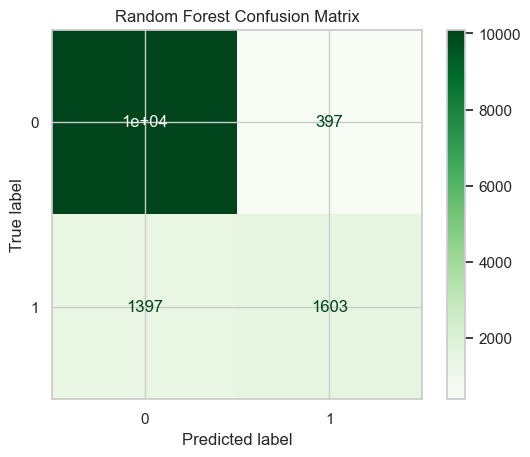

In [102]:
#confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)
ConfusionMatrixDisplay(confusion_matrix=rf_cm).plot(cmap=plt.cm.Greens)
plt.title("Random Forest Confusion Matrix")
plt.show()

### Random Forest Results ###
The Random Forest model achieved the following results:

- **Accuracy:** 0.87  
- **Precision:** 0.80  
- **Recall:** 0.53  
- **ROC AUC:** 0.84  

The confusion matrix shows that the model correctly identifies most rejected loans but misses a substantial portion of approved loans. This suggests that the model prioritises minimizing false approvals at the cost of lower recall.

### 4.3.2 Feature Importance Analysis

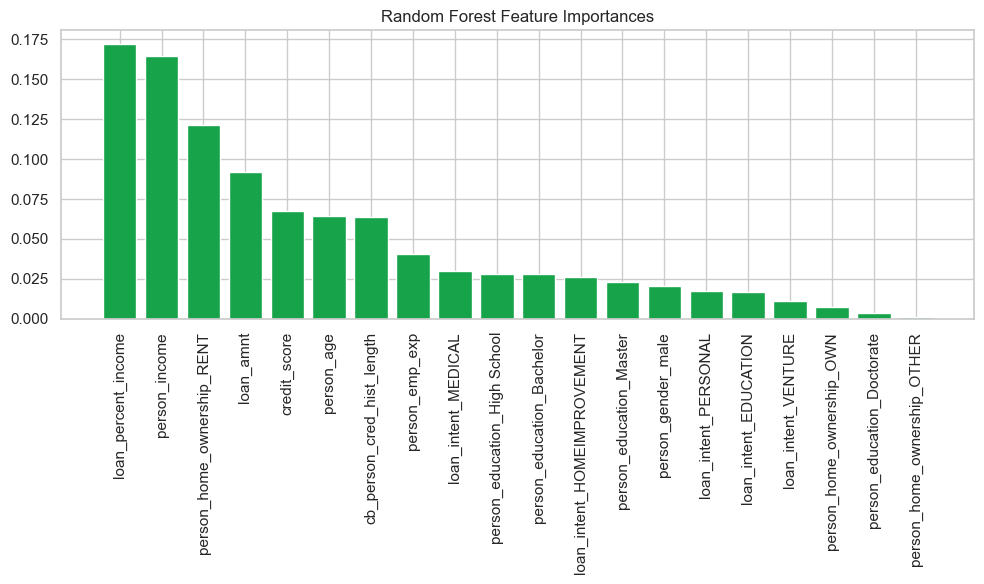

In [103]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train_res.columns

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(indices)), importances[indices], color=APPROVE_COLOR)
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


The feature importance results show that the model mainly relies on financial factors related to how affordable a loan is for an applicant. The most important features include:
- loan_percent_income
- person_income
- home ownership (renting)
- loan amount
- credit score
- employment experience and credit history length
- Factors such as demographics and other indirect indicators have much less influence on the model’s predictions.

Overall, this suggests that the models loan approval decisions are mostly determined by an applicant’s ability to afford the loan and manage debt, rather than the demographic characteristics.

### 4.3.3 ROC Curve Analysis

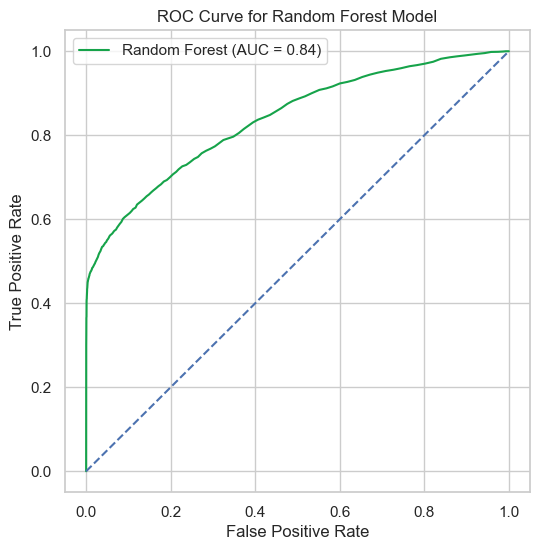

In [104]:
fpr, tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color=APPROVE_COLOR, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model')
plt.legend()
plt.show()

The ROC curve suggests that the model can generally tell approved and rejected loans apart, achieving an AUC of 0.84. While the model currently plays it safe, its predictions could be adjusted to approve more loans if the business is willing to accept additional risk.

## 4.4 XGBOOST
XGBoost was used as a second modeling approach due to its strong performance on structured tabular data and its ability to handle class imbalance natively.

Instead of using oversampling, class imbalance was addressed by setting the `scale_pos_weight` parameter. This adjusts the model to place more importance on the minority class (in this case, approved loans) during training.

In [105]:
#handle class imbalance natively
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.4.1 XGBoost Performance

In [106]:
#Print scores 

xgb_preds = xgb_base.predict(X_test)
xgb_probs = xgb_base.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

print(f"Accuracy: {accuracy_score(y_test, xgb_preds):.2f}")
print(f"Precision: {precision_score(y_test, xgb_preds):.2f}")
print(f"Recall: {recall_score(y_test, xgb_preds):.2f}")

xgb_auc = roc_auc_score(y_test, xgb_probs)
print(f"ROC AUC: {xgb_auc:.2f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     10498
           1       0.62      0.71      0.66      3000

    accuracy                           0.84     13498
   macro avg       0.77      0.79      0.78     13498
weighted avg       0.85      0.84      0.84     13498

Accuracy: 0.84
Precision: 0.62
Recall: 0.71
ROC AUC: 0.88


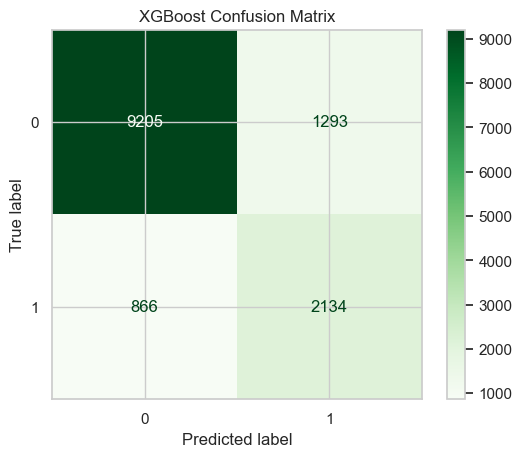

In [107]:
#confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_preds)
ConfusionMatrixDisplay(confusion_matrix=xgb_cm).plot(cmap=plt.cm.Greens)
plt.title("XGBoost Confusion Matrix")
plt.show()



XGBoost achieved the following results on the test set:

- **Accuracy:** 0.84  
- **Precision:** 0.62  
- **Recall:** 0.71  
- **ROC AUC:** 0.88  

Compared to the Random Forest model, XGBoost shows a clear increase in recall, showing it correctly identifies a higher proportion of approved loans. 
This comes at the cost of lower precision, suggesting more false approvals.
The confusion matrix further confirms this as XGBoost approves more loans overall but also allows more incorrect approvals compared to Random Forest.

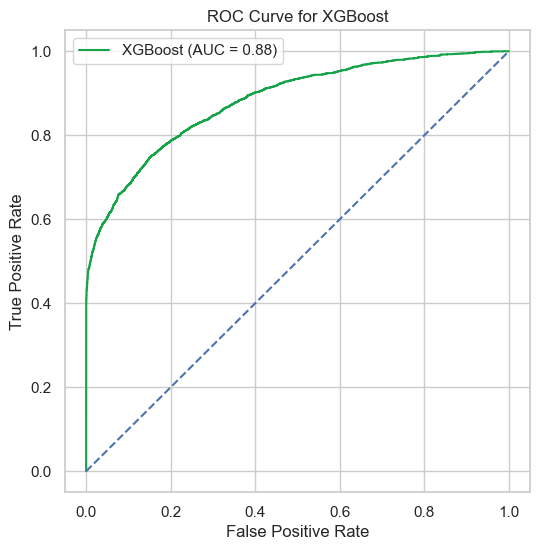

In [108]:
#ROC Curve

fpr, tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color=APPROVE_COLOR, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()

### 4.5 Hyperparameter Tuning on XGBOOST 
To improve performance further, hyperparameter tuning was performed using `RandomizedSearchCV` with ROC AUC as the evaluation metric. 
The tuning focused on tree depth, learning rate, number of estimators, and subsampling parameters.


In [109]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_tune = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

random_search = RandomizedSearchCV(
    xgb_tune,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [300, 500, 700],
                                        'subsample': [0.8, 1.0]},
                   scoring='roc_auc', verbose=1)

In [110]:
xgb_best = random_search.best_estimator_
random_search.best_params_

xgb_best_preds = xgb_best.predict(X_test)
xgb_best_probs = xgb_best.predict_proba(X_test)[:, 1]

print("XGBoost (Tuned) Classification Report:")
print(classification_report(y_test, xgb_best_preds))

xgb_best_auc = roc_auc_score(y_test, xgb_best_probs)
print(f"Tuned XGBoost ROC AUC: {xgb_best_auc:.2f}")

print("Best XGBoost parameters:")
print(random_search.best_params_)


XGBoost (Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     10498
           1       0.64      0.71      0.67      3000

    accuracy                           0.85     13498
   macro avg       0.78      0.80      0.79     13498
weighted avg       0.85      0.85      0.85     13498

Tuned XGBoost ROC AUC: 0.89
Best XGBoost parameters:
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


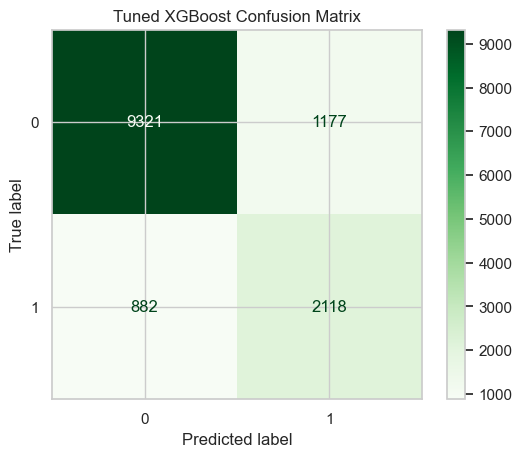

In [111]:
xgb_best_cm = confusion_matrix(y_test, xgb_best_preds)
ConfusionMatrixDisplay(confusion_matrix=xgb_best_cm).plot(cmap=plt.cm.Greens)
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()

Tuning resulted in a small and consistent improvement across most metrics, specifically ROC AUC, suggesting better overall ranking of loan applications.


### 4.5.1 ROC Curve Comparison

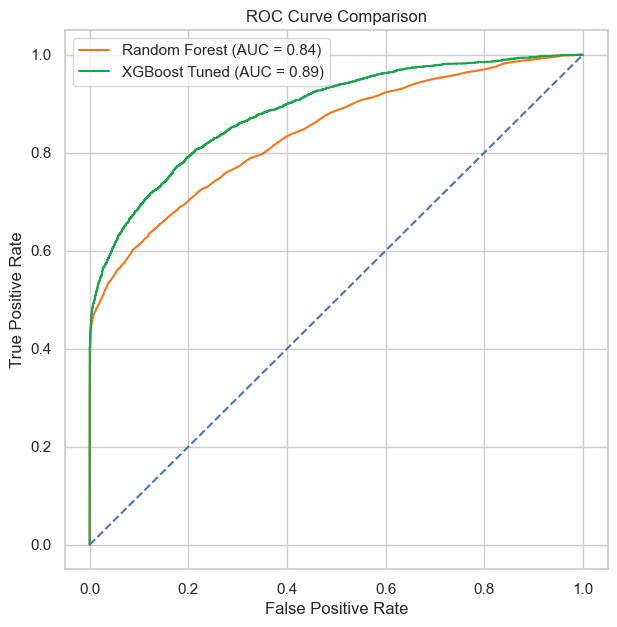

In [112]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_best_probs)

plt.figure(figsize=(7,7))
plt.plot(rf_fpr, rf_tpr, color=REJECT_COLOR, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color=APPROVE_COLOR, label=f'XGBoost Tuned (AUC = {xgb_best_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


The ROC curve comparison shows that both XGBoost models outperform Random Forest in terms of ranking ability. 
The tuned XGBoost model achieves the highest ROC AUC suggesting it is best at separating approved and rejected loans across different decision thresholds.

This makes XGBoost more suitable in scenarios where identifying as many valid approvals as possible is a priority.

### 4.5.2 Feature Importance (XGBoost)

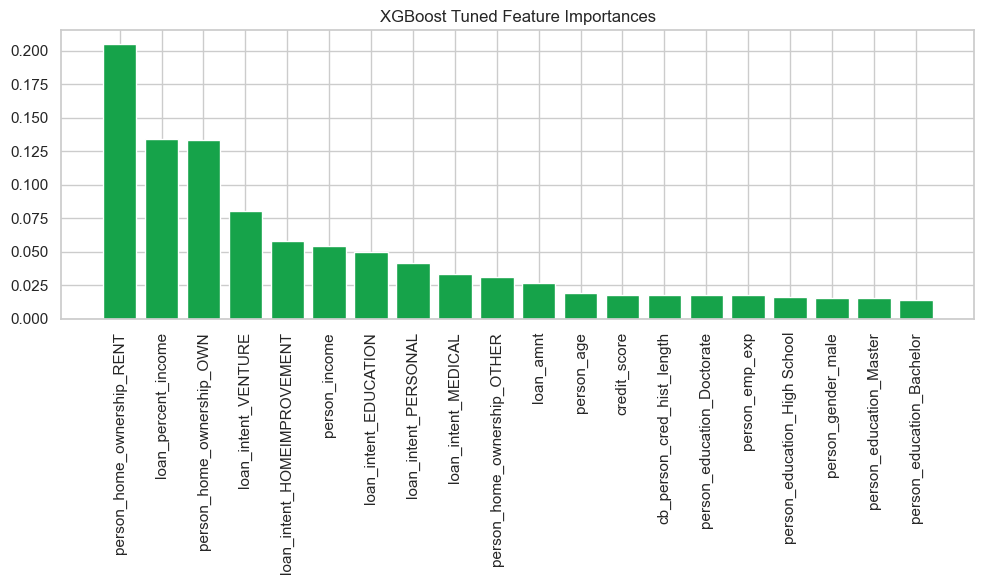

In [113]:
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_encoded.columns  # match encoded features

plt.figure(figsize=(10,6))
plt.title("XGBoost Tuned Feature Importances")
plt.bar(range(len(indices)), importances[indices], color=APPROVE_COLOR)
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

Feature importance results show that XGBoost relies mainly on financial factors, with the most important features including:

- **home ownership (renting specifically)**  
- **loan percent income**  
- **person income**  
- **loan intent (venture and home improvement)**  
- **loan amount**

Demographic variables and indirect indicators such as education level and gender have less influence influence.
Similar to Random Forest, XGBoost bases its decisions mostly on financial and borrowing risk rather than personal characteristics.

In [114]:

model_results = pd.DataFrame({
    "Model": [
        "Random Forest",
        "XGBoost (Baseline)",
        "XGBoost (Tuned)"
    ],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(y_test, xgb_best_preds)
    ],
    "Precision": [
        precision_score(y_test, rf_preds),
        precision_score(y_test, xgb_preds),
        precision_score(y_test, xgb_best_preds)
    ],
    "Recall": [
        recall_score(y_test, rf_preds),
        recall_score(y_test, xgb_preds),
        recall_score(y_test, xgb_best_preds)
    ],
    "F1 score": [
        f1_score(y_test, rf_preds),
        f1_score(y_test, xgb_preds),
        f1_score(y_test, xgb_best_preds)
    ],
    "ROC AUC": [
        rf_auc,
        xgb_auc,
        xgb_best_auc
    ]
})

model_results

,Model,Accuracy,Precision,Recall,F1 score,ROC AUC
0,Random Forest,0.867091,0.801500,0.534333,0.641200,0.838201
1,XGBoost (Baseline),0.840050,0.622702,0.711333,0.664073,0.882712
2,XGBoost (Tuned),0.847459,0.642792,0.706000,0.672915,0.885914


## 5. Conclusion

This project explored how machine learning can be used to support loan approval decisions using historical application data. The analysis covered data exploration, preprocessing, and the evaluation of two classification (Random Forest and XGBOOST) models under class imbalance.

Because only around 22% of loans in the dataset were approved, metrics such as recall and ROC-AUC were considered alongside accuracy. The Random Forest model performed well in avoiding incorrect approvals, achieving higher precision and overall accuracy, but it failed to identify many approved loans. In contrast, XGBoost achieved higher recall and stronger ROC AUC scores making it better at identifying applicants who are likely to be approved.

From a business perspective, the choice of model depends on risk tolerance. If the priority is to minimise risky approvals, a more conservative model like Random Forest may be beneficial. If the goal is to identify more eligible applicants and reduce missed opportunities, XGBoost offers a better balance for the organisation.

To conclude, the results show that loan approval decisions are largely driven by financial credit factors rather than demographic characteristics. This project shows how machine learning can be used to support lending decisions and highlights the balance between approving more loans and managing risk.
